<h1>Neural CLE Minimum Working Example<h1>

In [319]:
using DiffEqFlux
using SciMLSensitivity
using Optimization
using StochasticDiffEq, DiffEqCallbacks, DiffEqNoiseProcess
using Statistics, LinearAlgebra, Random
using Plots
using RecursiveArrayTools
using DiffEqBase.EnsembleAnalysis
using BenchmarkTools

We are interested in the Birth-Death system, which could be used to describe the population dynamics of a system of cells that has both a growth and death term proportional to its current population. The mathematics of the single ODE system are as follows:

$\frac{dX}{dt} = \alpha_1 X - \alpha_2 X$

For our purposes, what we are trying to show is that we can observe parts of the ODE from viewing the final output. So we rearrage this system for convenience (and generalizability)

$\frac{dX}{dt} = R_1 - R_2$

$\frac{dT_1}{dt} = R_1$

$\frac{dT_2}{dt} = R_2$

$R_1 = \alpha_1 X$

$R_2 = \alpha_2 X$

Where $T_1$ and $T_2$ are cumulative reaction rate curves. If we can predict these from the observable data (X), it is equivalent to being able to predict the reaction rates. We can generate training data for $X_0$ = 50, $\alpha_1$ = 0.2, $\alpha_2$ = 0.1. 

The CLE of this system would look like:
$\frac{dS}{dt} = \begin{bmatrix}
R_1 - R_2\\
R_1\\
R_2\\
\end{bmatrix} dt + 
\begin{bmatrix}
\sqrt{R_1} & -\sqrt{R_2}\\
\sqrt{R_1} & 0\\
0 & \sqrt{R_2}\\
\end{bmatrix}dW$

After we construct training data, the goal is to fit the CLE to the data using a neural network to predict $R_1$ and $R_2$.

In [258]:
u0 = Float64[50.; 0.;0]
datasize = 201
tspan = (0.0f0, 10.0f0)
tsteps = range(tspan[1], tspan[2], length = datasize)

0.0f0:0.05f0:10.0f0

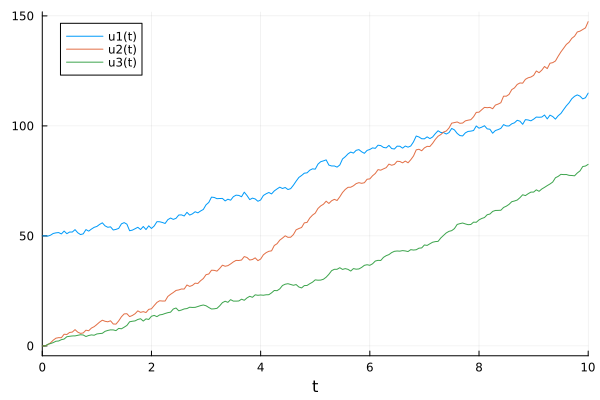

In [379]:
function trueSDEfunc(du, u, p, t)
    R1 = 0.2*u[1]
    R2 = 0.1*u[1]
    #Safety valve to prevent divergence to unstable values
    if u[1]>1000
        du[1] = 0
    else
        du[1] = R1-R2
    end
    du[2] = R1
    du[3] = R2
end

function true_noise_func(du, u, p, t)
    R1 = 0.2*u[1]
    R2 = 0.1*u[1]
    du[1, 1] = sqrt.(R1)[1]
    du[1, 2] = -sqrt.(R2)[1]
    du[2, 1] = sqrt.(R1)[1]
    du[3, 2] = 0
    du[3, 1] = 0
    du[3, 2] = sqrt.(R2)[1]
end
prob_truesde = SDEProblem(trueSDEfunc, true_noise_func, [50,0,0], tspan, noise_rate_prototype = zeros(3, 2))
nothing

sol = solve(prob_truesde, EM(), dt=0.05)
plot(sol)

We can generate a consistant testing set of means and variance by averaging an ensemble of function evaluations. 

In [674]:
ensembleprob = EnsembleProblem(prob_truesde)
@time sol = solve(ensembleprob, EM(), dt=0.05, saveat = 0.05, trajectories = 100000)
truemean = mean(sol, dims = 3)[:, :]
truevar = var(sol, dims = 3)[:, :];

  7.724124 seconds (28.97 M allocations: 3.018 GiB, 13.34% gc time, 14.55% compilation time: 98% of which was recompilation)


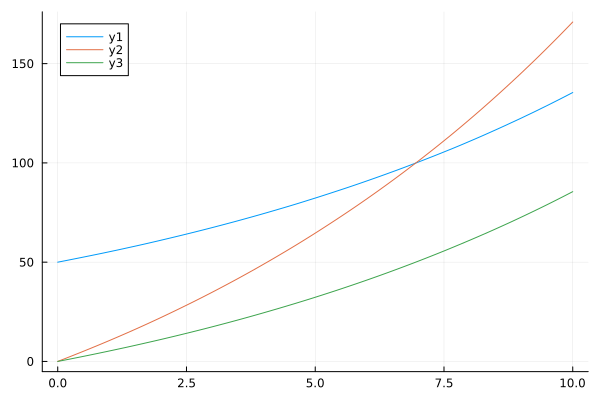

In [675]:
plot(LinRange(0,10,201),truemean')

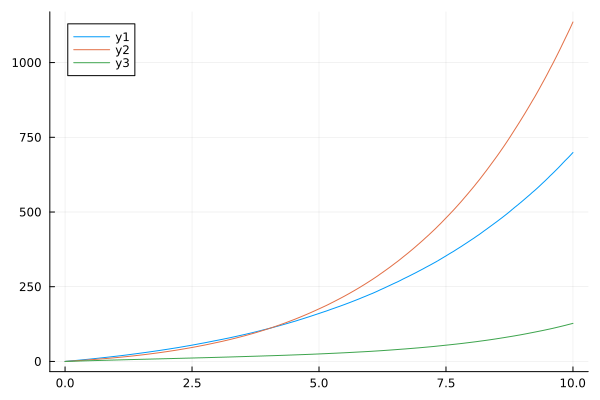

In [676]:
plot(LinRange(0,10,201),truevar')

Now we generate a neural SDE that can be trained on this data. We want to generate an SDEProblem that takes in two functions describing the drift and diffusion of our system. These functions, in turn, rely on the same neural network (with the same parameters) to predict the rates for them. Note that ratesmodel() only gets to access X.

In [402]:
function ratestodrift(u, p, t)
    R1,R2 = ratesmodel(u[1],p)
    #Safetly valve to keep bad parameter sets from crashing
    if abs(u[1])<1000
        reacprogress = R1-R2
    else
        reacprogress = 0
    end
    return [reacprogress,R1,R2]
end

function ratestodiff(u, p, t)
    R1,R2 = ratesmodel(u[1],p)
    return [[sqrt.(R1),sqrt.(R1),0] [-sqrt.(R2),0,sqrt.(R2)]]
end

ratestodiff (generic function with 2 methods)

We define the neural network using FastChains, which explicitly requires you to pass in a vector of parameters. p_nn is a randomly generated set of parameters that can be used as a starting point. 

┌ Warning: FastChain is being deprecated in favor of Lux.jl. Lux.jl uses functions with explicit parameters f(u,p) like FastChain, but is fully featured and documented machine learning library. See the Lux.jl documentation for more details.
└ @ DiffEqFlux C:\Users\ChemeGrad2021\.julia\packages\DiffEqFlux\jHIee\src\fast_layers.jl:9


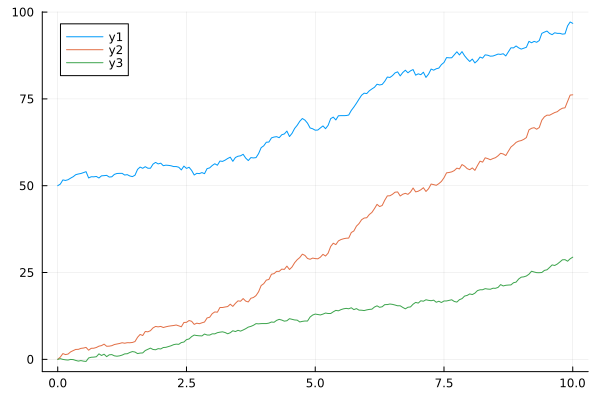

In [564]:
ratesmodel = FastChain(FastDense(1 , 16, relu), FastDense(16 , 2, relu));
p_nn = initial_params(ratesmodel);

prob = SDEProblem(ratestodrift, ratestodiff, u0, tspan, p_nn, noise_rate_prototype=zeros(3,2))
sol = solve(prob,EM(),dt = 0.05;sensealg=TrackerAdjoint())
plot(sol.t,Array(sol)')

In [616]:
function getprediction(p,u=u0)
    prob = SDEProblem(ratestodrift, ratestodiff, u, tspan, p, noise_rate_prototype=zeros(3,2))
    sol = solve(prob,EM(),dt = 0.05;sensealg=TrackerAdjoint())
    if (sol.retcode != ReturnCode.Success)
        print(p)
    end
    return Array(sol)
end

function predict_batch_neuralsde(p, n)
    res = map((x->getprediction(p,x)),[u0 for i in 1:n])
    VA = VectorOfArray(res)
    arr = convert(Array,VA)
end

function predictmeanvar(p,n)
    samples = predict_batch_neuralsde(p,n)
    means = mean(samples, dims = 3)
    vars = var(samples, dims = 3, mean = means)
    return means,vars
end

function loss_neuralsde(p; n = 100)
  means,vars = predictmeanvar(p,n)
  testmeans = means[1,:,:]
  testvars = vars[1,:,:]
  loss = sum(abs2, truemean[1,:] - testmeans) + sum(abs2, p) + sum(abs2, truevar[1,:] - testvars)
  return loss#, means, vars
end
#test = Zygote.gradient(loss_neuralsde,p_nn)

loss_neuralsde (generic function with 1 method)

Now that we have a loss function described, we can train our neural network. I had to set the training rate hyperparameter very low to avoid weird divergence in parameter updates. As such it takes a long time. The plots below shows the results - specifically (hopefully), that as the model converges to the testing data (X means and vars) it also converges to showing the hidden values correctly (R1 and R2 (cumulative)).

In [687]:
opt = ADAM(0.0001)

# First round of training with n = 10
adtype = Optimization.AutoZygote()
optf = Optimization.OptimizationFunction((x,p) -> loss_neuralsde(x), adtype)
optprob = Optimization.OptimizationProblem(optf, result1.u)#Change to p_nn if first time running
result1 = Optimization.solve(optprob, opt, maxiters = 1000);

In [688]:
loss_neuralsde(p_nn) #Inital parameter guess

8.450435625903767e6

In [689]:
loss_neuralsde(result1.u) #Parameters after training

41499.16386260459

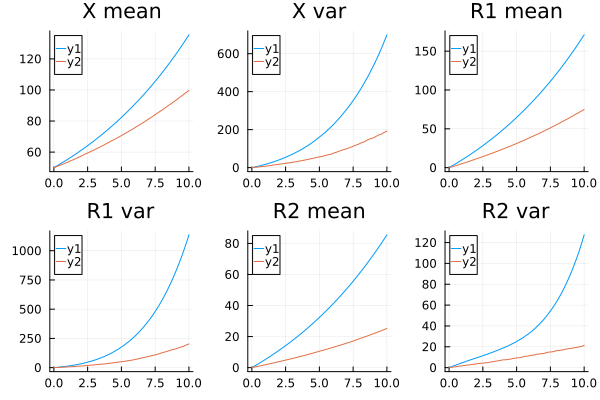

In [690]:
predres = predictmeanvar(p_nn,1000)#Inital parameter guess
plt1 = plot(tsteps,[truemean[1,:],predres[1][1,:,:]],title="X mean")
plt2 = plot(tsteps,[truevar[1,:],predres[2][1,:,:]],title="X var")
plt3 = plot(tsteps,[truemean[2,:],predres[1][2,:,:]],title="R1 mean")
plt4 = plot(tsteps,[truevar[2,:],predres[2][2,:,:]],title="R1 var")
plt5 = plot(tsteps,[truemean[3,:],predres[1][3,:,:]],title="R2 mean")
plt6 = plot(tsteps,[truevar[3,:],predres[2][3,:,:]],title="R2 var")
plot(plt1,plt2,plt3,plt4,plt5,plt6)

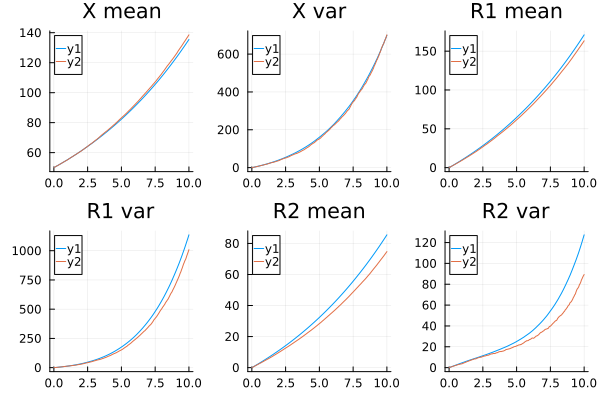

In [691]:
predres = predictmeanvar(result1.u,1000)#Parameters after training
plt1 = plot(tsteps,[truemean[1,:],predres[1][1,:,:]],title="X mean")
plt2 = plot(tsteps,[truevar[1,:],predres[2][1,:,:]],title="X var")
plt3 = plot(tsteps,[truemean[2,:],predres[1][2,:,:]],title="R1 mean")
plt4 = plot(tsteps,[truevar[2,:],predres[2][2,:,:]],title="R1 var")
plt5 = plot(tsteps,[truemean[3,:],predres[1][3,:,:]],title="R2 mean")
plt6 = plot(tsteps,[truevar[3,:],predres[2][3,:,:]],title="R2 var")
plot(plt1,plt2,plt3,plt4,plt5,plt6)

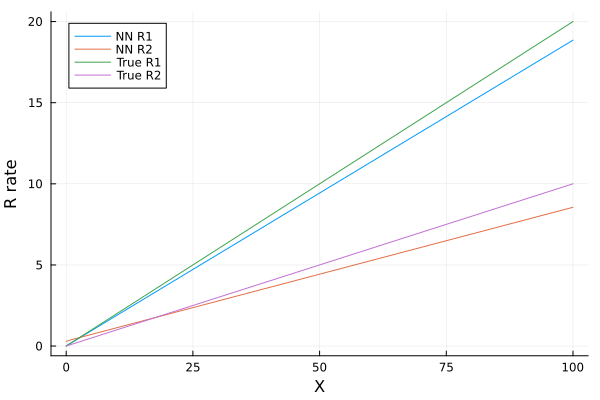

In [710]:
res = [ratesmodel(x,result1.u) for x in testX]
VA = VectorOfArray(res)
arr = convert(Array,VA)
plot(testX, arr[:,1,:]',xlabel = "X",ylabel = "R rate",label = ["NN R1" "NN R2"])
plot!(testX, [0.2*testX,0.1*testX],label = ["True R1" "True R2"])
